# T02. Analiza pe termen scurt (RO)

În acest tutorial vom introduce noțiunea de **analiză pe termen scurt** în domeniul timp a semnalului vocal. Aceasta mai este denumită și **analiză la nivel de cadru** sau **analiză cadru cu cadru**. 

Dar mai întâi să ne reamintim modul în care putem să citim eșantioanele și informațiile aferente unui semnal vocal:


In [1]:
import wave
import numpy as np

input_wav_file = './speech_files/a.wav'
wav_struct = wave.open(input_wav_file, 'r')

# Determinăm frecvența de eșantionare
sampling_frequency = wav_struct.getframerate()

# Determinăm rezoluția de bit
bit_depth = wav_struct.getsampwidth()

# Determinăm numărul de canale
no_channels = wav_struct.getnchannels()

# Citim eșantioanele
wav_bytes = wav_struct.readframes(-1)

# Convertim datele citite în valori întregi
wav_data = np.frombuffer(wav_bytes, dtype='int16')

# Închidem fluxul de intrare
wav_struct.close()

Și cum se ascultă și vizualizează datele audio:

Duration 0.253063 second


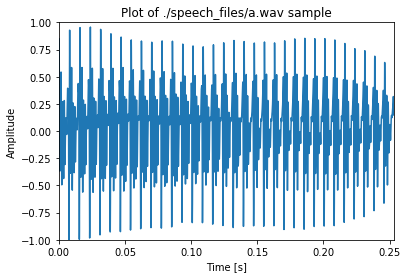

In [2]:
import matplotlib.pylab as pl
%matplotlib inline

# Normalizăm wav_data la [-1,1]
wav_data = wav_data/float(max(abs(wav_data)))

# Calculăm axa oX ca o secvență de multipli întregi ai perioadei de eșantionare
time_axis = np.arange(0, len(wav_data))*1.00/sampling_frequency

# Calculăm durata semnalului în secunde
duration = len(wav_data)*1.00/sampling_frequency
print ("Duration %f second" %duration)

# Afișăm datele cu axa oX având unitatea de timp
pl.plot(time_axis, wav_data)

pl.xlim([0, duration])
pl.ylim([-1, 1])

pl.xlabel('Time [s]')
pl.ylabel('Amplitude')
f = pl.title("Plot of %s sample" %input_wav_file)

In [3]:
# Ascultăm semnalul
import IPython
IPython.display.Audio(wav_data, rate=sampling_frequency)

# Caracteristici fundamentale ale semnalului vocal

Din punct de vedere fiziologic, sistemul de vorbire uman este compus din următoarele organe: plămâni, esofac, laringe, glottis (corzi vocale), faringe, cavitatea bucală, cavitatea nazală, limbă, uvulă, văl palatin, dinți, mandibulă și buze. Toate aceste organe sunt denumite **articulatori** și interacționează într-o manieră complexă pentru a realiza sunete.

Sursa vorbirii este fluxul de aer expirat din plămâni. Acest flux de aer este ulterior modulat în calea sa prin organele articulatoarea, ca mai apoi să producă vocea la ieșirea din cavitatea bucală sau nazală (sau combinat). Deși fiecare persoană are caracteristici individuale ale vocii, limba vorbită determină un set predefinit de poziții ale articulatorilor ce corespund setului de foneme utilizat în limba respectivă. Tranziția de la o poziția de articulare la alta este denumită **co-articulare**.


Datorită acestor tranziții și a modificării constante a poziției articulatorilor, semnalul vocal nu este staționar. 
Cu toate acestea, poate fi considerat ca fiind **cvasi-staționar** pe intervale de durată egală cu 20-40ms. Această durată este denumită **constanta de staționaritate** a semnalului vocal. În acest interval de timp, se poate face presupunerea că semnalul nu își schimbă în mod fundamental caracterisiticile, atât cele temporale, cât și cele spectrale. Ca urmare, înainte de a realiza orice tip de analiză sau extragere de caracteristici din semnalul vocal, acesta trebuie segmentat în **ferestre sau cadre de analiză**.  Durata cadrelor având un efect direct asupra numărului de eșantioane ce sunt procesate la un moment dat de către algoritm sau metoda de analiză.

De exemplu, pentru un semnal eșantionat la 16kHz vom folosi o fereastră de analiză de 320 - 640 de eșantioane. Într-un tutorial viitor vom discuta despre transformata Fourier și multiplele analize derivate din aceasta. Ca și o consecință a utilizării acestei transformate pe scară largă în prelucrarea semnalului vocal și în special a algoritmilor de calcul rapid a coeficienților Fourier, numărul de eșantioane dintr-un cadru este ales să fie egal cu o putere a lui 2 (de ex. 128, 256, 512, etc.). În plus, cadrele de analiză nu sunt disjuncte și de cele mai multe ori au un grad de suprapunere exprimat procentual (de ex. 50%, 25%, etc.)

Din punct de vedere al procesării de semnal, segmentarea semnalului în cadre de analiză este echivalentă cu înmulțirea semnalului cu o fereastră rectangulară de lungime egală cu constanta de staționaritate și care are diferite întârzieri. 

> **(OBS)** Noțiunile de *cadru de analiză* și *fereastră de analiză* vor fi utilizate interschimbabil fără însă a avea vreun efect asupra procesării datelor. 

# Analiza cadru cu cadru a semnalului vocal

Să încercăm atunci să împărțim semnalul vocal citit anterior în cadre de analiză.

În primul rând trebuie să determinăm lungimea ferestrei de analiză. Dacă semnalul vocal este cvasi-staționar pe o perioadă de 20 până la 40ms, numărul de eșantioane corespunzătoare acestei perioade este dependent de frecvența de eșantionare:

In [4]:
# Numărul de eșantioane dintr-un cadru de analiză de 20msec
window_length_20 = int(20*1e-3*sampling_frequency)

# Numărul de eșantioane dintr-un cadru de analiză de 40msec
window_length_40 = int(40*1e-3*sampling_frequency)

print ("The length of the analysis window should be between %d and %d samples" %(window_length_20, window_length_40))

The length of the analysis window should be between 320 and 640 samples


Astfel că, dacă alegem orice valoare cuprinsă între cele două valori calculate mai sus, semnalul vocal poate fi considerat staționar. 

In [5]:
# Selectăm durata cadrului de analiză la 20ms
window_length = window_length_20

În funcție de lungimea cadrului de analiză, vom calcula numărul întreg de cadre existente în semnalul de intrare. 

> **(OBS)** Dacă lungimea semnalului nu este egală cu un multiplu întreg al lungimii cadrului de analiză, ultimul cadru va fi analizat separat.

In [6]:
# Calculăm numărul întreg de cadre din semnalul de intrare
number_of_frames = int(len(wav_data)/window_length)
print ("Number of frames: %d" %number_of_frames)

Number of frames: 12


Extragem pe rând fiecare cadru de analiză din semnal și îl plotăm:

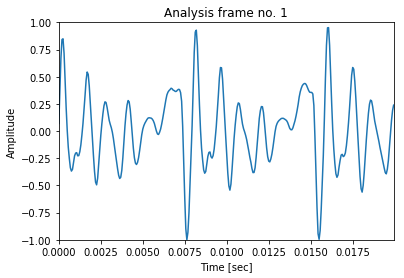

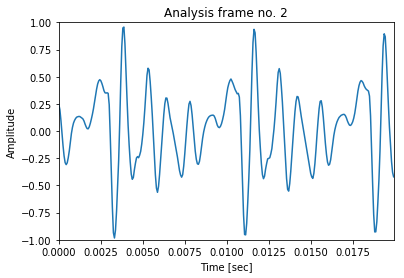

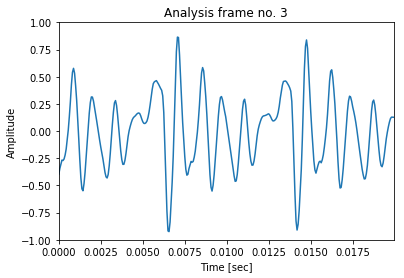

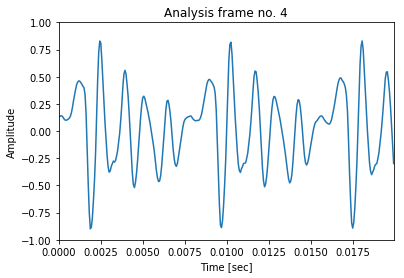

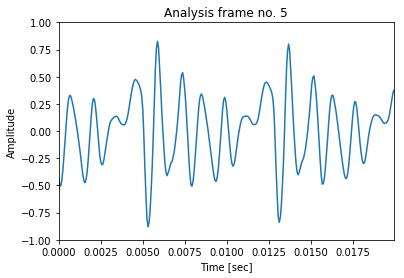

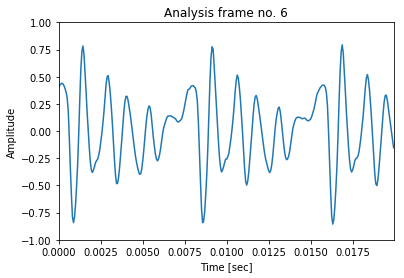

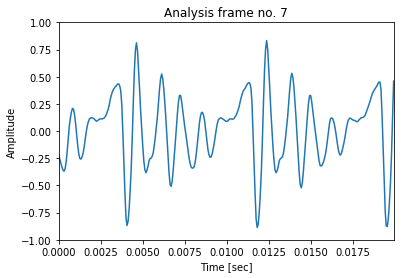

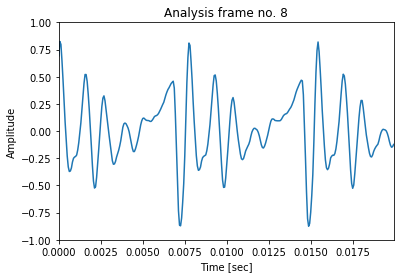

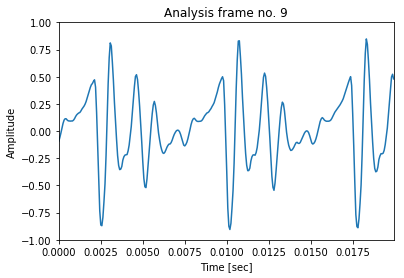

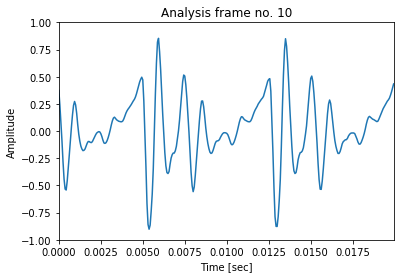

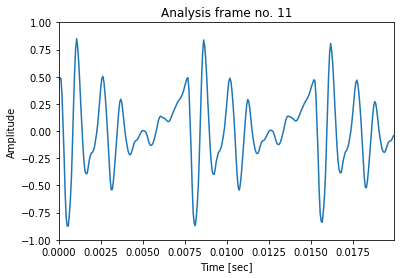

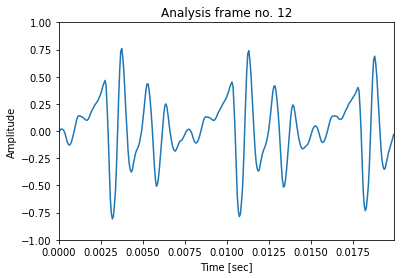

In [7]:
# Creăm variabila de timp pentru axa oX a plotului
time_axis = np.arange(0, window_length)*1.00/sampling_frequency

for k in range(number_of_frames):
    # Extragem doar un cadru din semnal
    # Echivalent cu înmulțirea semnalului cu o fereastră rectangulară
    # cu o întârziere egală cu i*window_length
    current_frame = wav_data[k*window_length: (k+1)*window_length]
    
    # Plot
    pl.figure()
    pl.plot(time_axis, current_frame)
    pl.title("Analysis frame no. %d" %(k+1))
    pl.xlabel('Time [sec]')
    pl.ylabel('Amplitude')
    pl.xlim((0, time_axis[-1]))
    pl.ylim((-1, 1))
    

<table>
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex5.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em">A. Modificați valorile lungimii cadrului de analiză și analizați rezultatele. Folosiți valorile 32, 64, 128 și 256 și afișați rezultatele pentru un singur cadru de analiză.
    </td>
</tr>
</table>

In [8]:
###################
##YOUR CODE HERE
###################

<table style="width:100%">

<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex3.png' width=50 align="left"> </td>
    <td style="text-align:left; font-size:1.2em"> B. Schimbați fișierul de intrare cu unul ce conține o consoană și afișați rezultatele. </td>
</tr>
</table>

In [9]:
###################
##YOUR CODE HERE
###################

# Tipuri de ferestre de analiză

Exemplele anterioare au folosit (nu în mod explicit) o fereastră de analiză de tip rectangular. Acest lucru înseamnă că toate eșantioanele din fereastră au ponderi egale în cadrul analizei ulterioare. Însă, în practică, se folosesc mai degrabă ferestre cu ponderi variabile, precum Hamming, Hanning sau Blackman. Ce este comun acestora, este faptul că eșantioanele din centrul ferestrei sunt ponderate unitar, iar cele de la extremități au ponderi ce tind spre 0. În afara ferestrei de analiză, ponderile sunt 0. 

Fereastra Hamming: https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.signal.hamming.html

Fereastra Hanning: https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.signal.hanning.html

Fereastra Blackman: https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.blackman.html

În secvența de cod de mai jos afișăm forma acestor ferestre folosindu-ne de funcțiile ale modulul SciPy https://www.scipy.org/:

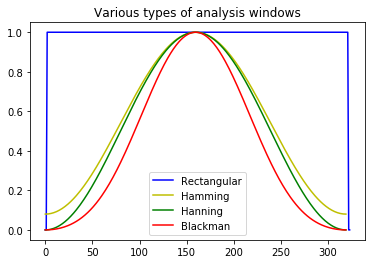

In [10]:
# Importăm funcțiile aferente ferestrelor de analiză;
# boxcar este fereastra rectangulară
from scipy.signal import boxcar, hamming, hann, blackman

# Generăm o fereastră rectangulară puțin mai lungă pentru
# a putea vizualiza forma acesteia în mod corect.
boxcar_window = np.zeros(window_length+4)
boxcar_window[2:window_length+2] = boxcar(window_length)

# Generăm ferestrele Hamming, Hanning și Blackman
hamming_window = hamming(window_length)
hanning_window = hann(window_length)
blackman_window = blackman(window_length)

# Plotăm ferestrele
pl.title('Various types of analysis windows')
pl.plot(boxcar_window, 'b')
pl.plot(hamming_window, 'y')
pl.plot(hanning_window, 'g')
pl.plot(blackman_window, 'r')
pl.legend(['Rectangular', 'Hamming', 'Hanning', 'Blackman']);

Plotul de mai sus afișează doar ponderile date de fiecare fereastră. Dacă dorim să vedem efectul ferestrelor asupra semnalului vocal trebuie să le aplicăm asupra cadrelor de analiză:

Text(0.5,1,'Frame with Blackman window applied')

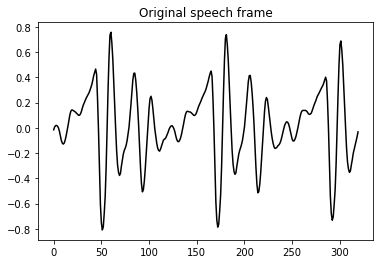

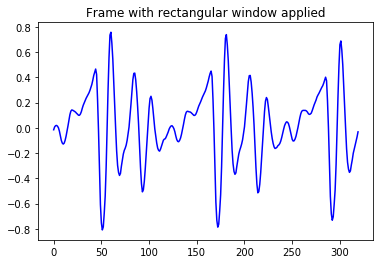

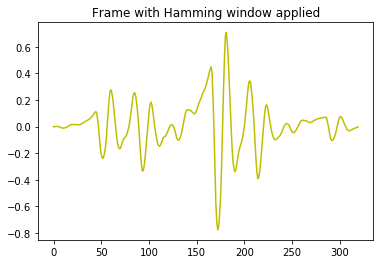

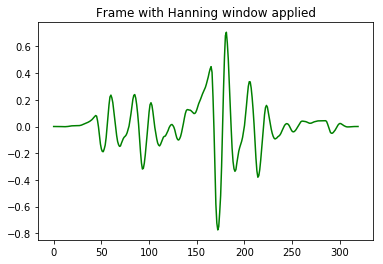

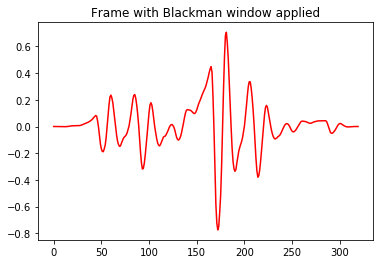

In [11]:
# Selectăm un singur cadru din semnalul vocal, cadrul 2
k = 2
one_frame = wav_data[k*window_length: (k+1)*window_length]

# Înmulțim cadrul cu fiecare fereastră în parte.
# Înmulțirea se realizează element cu element.
boxcar_window = boxcar(window_length)
rectangular_frame = np.multiply(boxcar_window, current_frame)
hamming_frame = np.multiply(hamming_window, current_frame)
hanning_frame = np.multiply(hanning_window, current_frame)
blackman_frame = np.multiply(blackman_window, current_frame)

# Plot
pl.plot(current_frame, 'k')
pl.title('Original speech frame')

pl.figure()
pl.plot(rectangular_frame, 'b')
pl.title('Frame with rectangular window applied')

pl.figure()
pl.plot(hamming_frame, 'y')
pl.title('Frame with Hamming window applied')


pl.figure()
pl.plot(hanning_frame, 'g')
pl.title('Frame with Hanning window applied')

pl.figure()
pl.plot(hanning_frame, 'r')
pl.title('Frame with Blackman window applied')

Se poate observa efectul de ponderare al amplitudinii eșantioanelor din extremitățile ferestrei de analiză pentru ultimele 3 tipuri de fereastră.

# Răspunsul în frecvență al ferestrelor de analiză și fenomenul de *spectral leakage*

În momentul de față s-ar putea să nu fie clar de ce e nevoie ca fiecare eșantion din fereastra de analiză să fie ponderat diferit. Astfel că introducem aici o noțiune necesară, însă puțin mai avansată, aceea de **răspuns în frecvență**. Această noțiune va fi reluată mai pe larg în cadrul tutorialului de analiză în frecvență și transformată Fourier. 

Am menționat anterior faptul că aplicarea unei ferestre de analiză asupra semnalului este echivalentă cu înmulțirea semnalului cu o serie de coeficienți ce sunt 0 în afara ferestrei. Acest lucru nu afectează doar amplitudinea semnalului, ci și spectrul său. În domeniu spectral, acest fenomen este cunoscut sub numele de **spectral leakage** și înseamnă că energia lobului spectral principal se va disipa și în lobii adiacenți. Fiecare tip de fereastră de analiză are un grad diferit de disipare, iar ploturile de mai jos exemplifică acest fapt:
   

> **(OBS)** Mai multe informații:

> https://en.wikipedia.org/wiki/Spectral_leakage
> https://www.researchgate.net/post/What_is_spectral_leakage_What_is_scalloping_What_causes_themin_DFT_or_FFT_How_could_I_reduce_their_effect


> **(OBS)** - Nu e necesară înțelegerea codului de mai jos momentan!

/home/adriana/.local/lib/python2.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log10
/home/adriana/.local/lib/python2.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log10


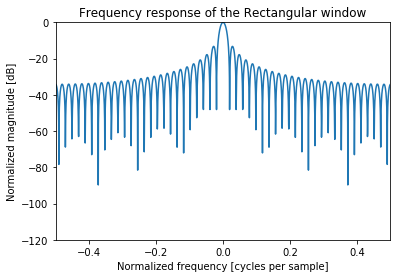

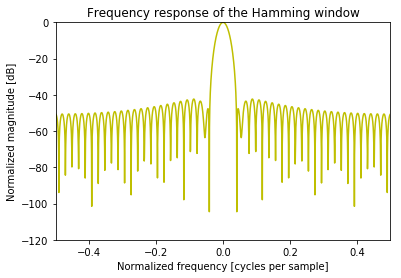

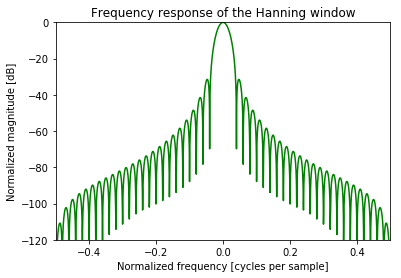

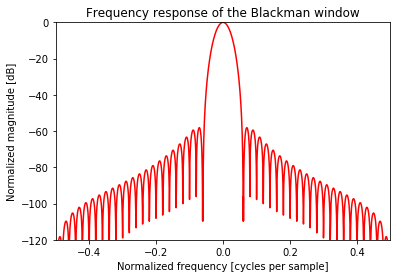

In [12]:
from scipy.fftpack import fft, fftshift


pl.figure()
window =  boxcar(51)
window_fft = fft(window, 2048) / (len(window)/2.0)
frequency_axis = np.linspace(-0.5, 0.5, len(window_fft))
response = 20 * np.log10(np.abs(fftshift(window_fft / abs(window_fft).max())))
pl.plot(frequency_axis, response)
pl.axis([-0.5, 0.5, -120, 0])
pl.title("Frequency response of the Rectangular window")
pl.ylabel("Normalized magnitude [dB]")
pl.xlabel("Normalized frequency [cycles per sample]")


pl.figure()
window =  hamming(51)
window_fft = fft(window, 2048) / (len(window)/2.0)
frequency_axis = np.linspace(-0.5, 0.5, len(window_fft))
response = 20 * np.log10(np.abs(fftshift(window_fft / abs(window_fft).max())))
pl.plot(frequency_axis, response, 'y')
pl.axis([-0.5, 0.5, -120, 0])
pl.title("Frequency response of the Hamming window")
pl.ylabel("Normalized magnitude [dB]")
pl.xlabel("Normalized frequency [cycles per sample]")



pl.figure()
window = hann(51)
window_fft = fft(window, 2048) / (len(window)/2.0)
frequency_axis = np.linspace(-0.5, 0.5, len(window_fft))
response = 20 * np.log10(np.abs(fftshift(window_fft / abs(window_fft).max())))
pl.plot(frequency_axis, response, 'g')
pl.axis([-0.5, 0.5, -120, 0])
pl.title("Frequency response of the Hanning window")
pl.ylabel("Normalized magnitude [dB]")
pl.xlabel("Normalized frequency [cycles per sample]")


pl.figure()
window = blackman(51)
window_fft = fft(window, 2048) / (len(window)/2.0)
frequency_axis = np.linspace(-0.5, 0.5, len(window_fft))
response = 20 * np.log10(np.abs(fftshift(window_fft / abs(window_fft).max())))
pl.plot(frequency_axis, response, 'r')
pl.axis([-0.5, 0.5, -120, 0])
pl.title("Frequency response of the Blackman window")
pl.ylabel("Normalized magnitude [dB]")
pl.xlabel("Normalized frequency [cycles per sample]");

Ar trebui să remarcăm faptul că fenomenul de spectral leakage este cel mai pronunțat pentru fereastra rectangulară.

În aplicații practice, se folosește de cele mai multe ori fereastra Hamming datorită atenuării constante din afara lobului principal.

# Cadre de analiză suprapuse

În toate exemplele de mai sus am folosit cadre de analiză disjuncte. Acest lucru înseamnă că per global, eșantioanele din marginile ferestrei nu vor avea o influență egală cu cele centrale în analizele ulterioare, fapt ce nu este de dorit. Pentru a evita acest lucru trebuie să utilizăm cadre de analiză suprapuse, astfel încât toate eșantioanele sau cel puțin majoritatea lor să se afle la un moment dat în centrul ferestrei de analiză. 

**Factorul de suprapunere** reprezintă gradul de suprapunere al cadrelor și poate fi ales în domeniul $p\in [0,1)$ (sau exprimat procentual între 0 și 100%), unde 0 înseamnă fără suprapunere, iar 1 este complet suprapus (nu are utilitate practică). Figura de mai jos afișează cazul unei suprapuneri de 0.33 (33%).

<p><img src="images/02_cadre_50.png"></p>

Astfel că, vom schimba codul anterior pentru a putea utiliza și o variabilă ce reprezintă factorul de suprapunere al cadrelor, `p`:

In [13]:
# Definim factorul de suprapunere
p = 0.2

# Stabilim o lungime a ferestrei egală cu 100 de eșantioane
window_length = 100

# Calculăm numărul de cadre
number_of_frames = int(len(wav_data)/((1-p)*window_length))

# Extragem cadrele suprapuse din semnal
for k in range(number_of_frames):
    current_frame = wav_data[int(k*(1-p)*window_length):int((k*(1-p)+1)*window_length)]

<table style="width:100%">
<tr style="color:#FF5733; font-weight:bold">
    <td style="width:6%">
        <img src='images/ex1.png' width=50 text-align="left"> 
    </td>
    <td style="text-align:left; font-size:1.2em">C. Modificați factorul de suprapunere și afișați rezultatele pentru primele 5 cadre de semnal vocal.
    </td>
</tr>
</table>

In [14]:
###################
##YOUR CODE HERE
###################

**Ultimul cadru de analiză (dacă există)**

În ambele cazuri, cu sau fără suprapunerea ferestrelor de analiză, dacă lungimea semnalului nu este egală cu un multiplu întreg al lungimii cadrului de analiză, trebuie să ținem cont și de ultimul cadru și să îl tratăm în mod individual:

In [15]:
# Ultimul cadru de analiză 
last_frame = wav_data[number_of_frames*window_length:]

# Concluzii

În cadrul acestui tutorial am reușit să extragem din semnalul vocal de intrare câte un cadru de analiză, astfel încât să putem realiza analize ulterioare asupra semnalului, analize ce necesită ipoteza de staționaritate a semnalului. Am văzut, totodată, și efectul diferitelor tipuri de ferestre de analiză asupra semnalului vocal și modul în care acestea se comportă în domeniul frecvenței.